<a href="https://colab.research.google.com/github/Saba-a11/Kaggle_Credit_Score/blob/main/CreditModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries

In [56]:
from ast import increment_lineno
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
%matplotlib inline


# numbers and plot formatting
pd.set_option('display.float_format', lambda x: '{:,.2f}'.format(x))
sns.set_palette('plasma')    # magma, crest, rocket_r, flare, mako, rocket, viridis, plasma, cividis
sns.set_style('whitegrid')


def prt_corr(df, column_of_interest, target_column):
  # Calculate the correlation
  correlation = df[column_of_interest].corr(df[target_column])
  print(f"Correlation between {column_of_interest} and {target_column}: {correlation}")


def scatter_plot(df, column_of_interest, target_column):
  # Scatter plot
  plt.figure(figsize=(8, 6))
  sns.scatterplot(x=df[column_of_interest], y=df[target_column])
  plt.title(f'Scatter Plot between {column_of_interest} and {target_column}')
  plt.xlabel(column_of_interest)
  plt.ylabel(target_column)
  plt.show()


def box_plot(df, column_of_interest):
  # Assuming combined_data is your DataFrame
  plt.figure(figsize=(10, 6))
  sns.boxplot(x=df[column_of_interest], palette="Set1")
  plt.title(f'Boxplot for {column_of_interest}')
  plt.xlabel(column_of_interest)
  plt.show()


def heatmap_plot(df):
  # Create a heatmap
  plt.figure(figsize=(10, 8))
  sns.heatmap(df, annot=True, cmap='coolwarm', linewidths=.5)
  plt.title('Heatmap for the Dataset')
  plt.show()


def calculate_woe_iv(df, target_column, feature_column, bins=10):
    """
    Calculate Weight of Evidence (WOE) and Information Value (IV) for a given feature.

    Parameters:
    - df: DataFrame containing the data.
    - target_column: Name of the target variable column.
    - feature_column: Name of the feature variable column for which WOE and IV are calculated.
    - bins: Number of bins for discretizing the continuous variable.

    Returns:
    - woe_iv_df: DataFrame containing WOE, IV, and count values for each bin.
    """
    # Create a copy of the input DataFrame to avoid modifying the original
    df_copy = df.copy()

    # Discretize the feature variable into bins
    df_copy['binned_feature'] = pd.qcut(df_copy[feature_column], q=bins, duplicates='drop')

    # Calculate the count of positive and negative instances in each bin
    grouped_df = df_copy.groupby('binned_feature').agg({
        target_column: ['count', 'sum']
    }).reset_index()

    grouped_df.columns = ['binned_feature', 'total_count', 'positive_count']

    # Calculate the count of negative instances in each bin
    grouped_df['negative_count'] = grouped_df['total_count'] - grouped_df['positive_count']

    # Calculate the proportion of positive and negative instances in each bin
    grouped_df['positive_rate'] = grouped_df['positive_count'] / grouped_df['positive_count'].sum()
    grouped_df['negative_rate'] = grouped_df['negative_count'] / grouped_df['negative_count'].sum()

    # Calculate WOE and IV
    grouped_df['woe'] = np.log(grouped_df['positive_rate'] / grouped_df['negative_rate'])
    grouped_df['iv'] = (grouped_df['positive_rate'] - grouped_df['negative_rate']) * grouped_df['woe']

    # Add a count column to represent the number of observations in each bin
    grouped_df['count'] = grouped_df['total_count']

    # Sum up IV values for each bin
    total_iv = grouped_df['iv'].sum()

    # Sort the DataFrame by the feature values
    woe_iv_df = grouped_df.sort_values(by='binned_feature').reset_index(drop=True)

    # Display Information Value (IV) for the entire feature
    print(f"Information Value (IV) for {feature_column}: {total_iv}")

    return woe_iv_df[['binned_feature', 'woe', 'iv', 'count']]



def plot_woe(df_WoE, rotation_of_x_axis_labels = 0):
    x = np.array(df_WoE.iloc[: , 0].apply(str))
    y = df_WoE['woe']
    plt.figure(figsize = (18, 6))
    plt.plot(x, y, marker = 'o', linestyle = '--', color = 'k')
    plt.xlabel(df_WoE.columns[0])
    plt.ylabel('Weight of Evidence')
    plt.title(str('Weight of Evidence by ' + df_WoE.columns[0]))
    plt.xticks(rotation = rotation_of_x_axis_labels)
    plt.show()


# Import Data

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [145]:
df_train = pd.read_csv("/content/drive/MyDrive/Data_Kaggle_GiveMeSomeCredit/cs-training.csv")
df_test = pd.read_csv("/content/drive/MyDrive/Data_Kaggle_GiveMeSomeCredit/cs-test.csv")

In [4]:
df_train.head()

,Unnamed: 0,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,1,1,0.77,45,2,0.80,"9,120.00",13,0,6,0,2.00
1,2,0,0.96,40,0,0.12,"2,600.00",4,0,0,0,1.00
2,3,0,0.66,38,1,0.09,"3,042.00",2,1,0,0,0.00
3,4,0,0.23,30,0,0.04,"3,300.00",5,0,0,0,0.00
4,5,0,0.91,49,1,0.02,"63,588.00",7,0,1,0,0.00


In [5]:
df_test.head()

,Unnamed: 0,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,1,NaN,0.89,43,0,0.18,"5,700.00",4,0,0,0,0.00
1,2,NaN,0.46,57,0,0.53,"9,141.00",15,0,4,0,2.00
2,3,NaN,0.04,59,0,0.69,"5,083.00",12,0,1,0,2.00
3,4,NaN,0.28,38,1,0.93,"3,200.00",7,0,2,0,0.00
4,5,NaN,1.00,27,0,0.02,"3,865.00",4,0,0,0,1.00


### based on Data Dictionary, Variable Name, Description and Type are:

* `SeriousDlqin2yrs` Person experienced 90 days past due delinquency or
worse. **Y/N**
* `RevolvingUtilizationOfUnsecuredLines` Total balance on credit cards and personal lines of credit except real estate and no installment debt like car loans divided by the sum of credit limits. **percentage**
* `age` Age of borrower in years. **integer**
* `NumberOfTime3059DaysPastDueNotWorse` Number of times borrower has been 30-59 days past due but no worse in the last 2 years. **integer**
* `DebtRatio` Monthly debt payments, alimony,living costs divided by monthy gross income **percentage**
* `MonthlyIncome Monthly` income **real**
* `NumberOfOpenCreditLinesAndLoans` Number of Open loans (installment like car loan or mortgage) and Lines of credit (e.g. credit cards) **integer**
* `NumberOfTimes90DaysLate` Number of times borrower has been 90 days or more past due. **integer**
* `NumberRealEstateLoansOrLines` Number of mortgage and real estate loans including home equity lines of credit **integer**
* `NumberOfTime60-89DaysPastDueNotWorse` Number of times borrower has been 60-89 days past due but no worse in the last 2 years. **integer**
* `NumberOfDependents` Number of dependents in family excluding themselves (spouse, children etc.) **integer**

# Exploratory Data Analysis

In [6]:
print('Train shape: ', df_train.shape)
print('Test shape: ', df_test.shape)

Train shape:  (150000, 12)
Test shape:  (101503, 12)


In [7]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 12 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   Unnamed: 0                            150000 non-null  int64  
 1   SeriousDlqin2yrs                      150000 non-null  int64  
 2   RevolvingUtilizationOfUnsecuredLines  150000 non-null  float64
 3   age                                   150000 non-null  int64  
 4   NumberOfTime30-59DaysPastDueNotWorse  150000 non-null  int64  
 5   DebtRatio                             150000 non-null  float64
 6   MonthlyIncome                         120269 non-null  float64
 7   NumberOfOpenCreditLinesAndLoans       150000 non-null  int64  
 8   NumberOfTimes90DaysLate               150000 non-null  int64  
 9   NumberRealEstateLoansOrLines          150000 non-null  int64  
 10  NumberOfTime60-89DaysPastDueNotWorse  150000 non-null  int64  
 11  

In [8]:
df_train.describe()

,Unnamed: 0,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
count,"150,000.00","150,000.00","150,000.00","150,000.00","150,000.00","150,000.00","120,269.00","150,000.00","150,000.00","150,000.00","150,000.00","146,076.00"
mean,"75,000.50",0.07,6.05,52.30,0.42,353.01,"6,670.22",8.45,0.27,1.02,0.24,0.76
std,"43,301.41",0.25,249.76,14.77,4.19,"2,037.82","14,384.67",5.15,4.17,1.13,4.16,1.12
min,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,"37,500.75",0.00,0.03,41.00,0.00,0.18,"3,400.00",5.00,0.00,0.00,0.00,0.00
50%,"75,000.50",0.00,0.15,52.00,0.00,0.37,"5,400.00",8.00,0.00,1.00,0.00,0.00
75%,"112,500.25",0.00,0.56,63.00,0.00,0.87,"8,249.00",11.00,0.00,2.00,0.00,1.00
max,"150,000.00",1.00,"50,708.00",109.00,98.00,"329,664.00","3,008,750.00",58.00,98.00,54.00,98.00,20.00


In [9]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101503 entries, 0 to 101502
Data columns (total 12 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   Unnamed: 0                            101503 non-null  int64  
 1   SeriousDlqin2yrs                      0 non-null       float64
 2   RevolvingUtilizationOfUnsecuredLines  101503 non-null  float64
 3   age                                   101503 non-null  int64  
 4   NumberOfTime30-59DaysPastDueNotWorse  101503 non-null  int64  
 5   DebtRatio                             101503 non-null  float64
 6   MonthlyIncome                         81400 non-null   float64
 7   NumberOfOpenCreditLinesAndLoans       101503 non-null  int64  
 8   NumberOfTimes90DaysLate               101503 non-null  int64  
 9   NumberRealEstateLoansOrLines          101503 non-null  int64  
 10  NumberOfTime60-89DaysPastDueNotWorse  101503 non-null  int64  
 11  

In [10]:
df_test.describe()

,Unnamed: 0,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
count,"101,503.00",0.00,"101,503.00","101,503.00","101,503.00","101,503.00","81,400.00","101,503.00","101,503.00","101,503.00","101,503.00","98,877.00"
mean,"50,752.00",NaN,5.31,52.41,0.45,344.48,"6,855.04",8.45,0.30,1.01,0.27,0.77
std,"29,301.54",NaN,196.16,14.78,4.54,"1,632.60","36,508.60",5.14,4.52,1.11,4.50,1.14
min,1.00,NaN,0.00,21.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,"25,376.50",NaN,0.03,41.00,0.00,0.17,"3,408.00",5.00,0.00,0.00,0.00,0.00
50%,"50,752.00",NaN,0.15,52.00,0.00,0.36,"5,400.00",8.00,0.00,1.00,0.00,0.00
75%,"76,127.50",NaN,0.56,63.00,0.00,0.85,"8,200.00",11.00,0.00,2.00,0.00,1.00
max,"101,503.00",NaN,"21,821.00",104.00,98.00,"268,326.00","7,727,000.00",85.00,98.00,37.00,98.00,43.00


## EDA Results:


* `Unnamed: 0`:
    * Customer Identifier
    * Rename: ID
    * Irrelevant in modeling
* `SeriousDlqin2yrs`:
    * Encoded as 0 for No, 1 for Yes.
    * Negative to positive delinquency outliers: 93.3% to 6.7%.
    * Target feature highly imbalanced and need to manage by some strategies.
* `RevolvingUtilizationOfUnsecuredLines`:
    * Distribution has Right-skewed values.
    * Anticipate increased defaults with rising ratios.
    * Values higher than 1 seem outlier.
* `age`:
    * Minimum Age set at 0, considered incorrect.
    * Maximum age at 109, deemed peculiar.

**Overdue Payment Indicators:**
* `NumberOfTime30-59DaysPastDueNotWorse`
* `NumberOfTime60-89DaysPastDueNotWorse`
* `NumberOfTimes90DaysLate`
    * The outlier intervention in our indicators. numbers 96 and 98 appears repeatedly.
    * A percentile 99% of our values hovered around 2 and 3, and anything beyond felt like an outlier.
* `DebtRatio`:
    * Distribution has Right-skewed values.
    * Values higher than 1 seem outlier.
    * A zero ratio is deemed dangerous and needs management.
    * Anticipate decrease defaults with rising ratios.
* `MonthlyIncome`:
    * Exhibit null values, necessitating appropriate handling procedures.
* `NumberOfOpenCreditLinesAndLoans`:
    * Maximum number points to outliers.
    * outliers seem in this feature, 75% of the feature lies below 11.
* `umberRealEstateLoansOrLines`:
    * Maximum number points to outliers.
    * outliers seem in this feature, 95% of the feature lies below 3.
* `NumberOfDependents`:
    * Exhibit null values, necessitating appropriate handling procedures.


* The preliminary analysis of the **train** and **test** datasets indicates a congruent behavior between the two. Consequently, we opt to merge them during the data preprocessing phase for streamlined processing and analysis.



# Data Preprocessing

### Unnamed: 0 Column

The column labeled `Unnamed: 0` lacks significance within the context of predictive modeling, serving solely as a representation of customer identification. Rename this column to `ID` for future reference, It will not play a role in the modeling process.

In [146]:
df_train.rename(columns={'Unnamed: 0':'ID'}, inplace=True)
df_test.rename(columns={'Unnamed: 0':'ID'}, inplace=True)

### SeriousDlqin2yrs Column

An imbalanced target column in a dataset, particularly in the context of binary classification, implies that the distribution of the classes is uneven. `SeriousDlqin2yrs` column has an imbalance, with a default rate of **6.7%**.

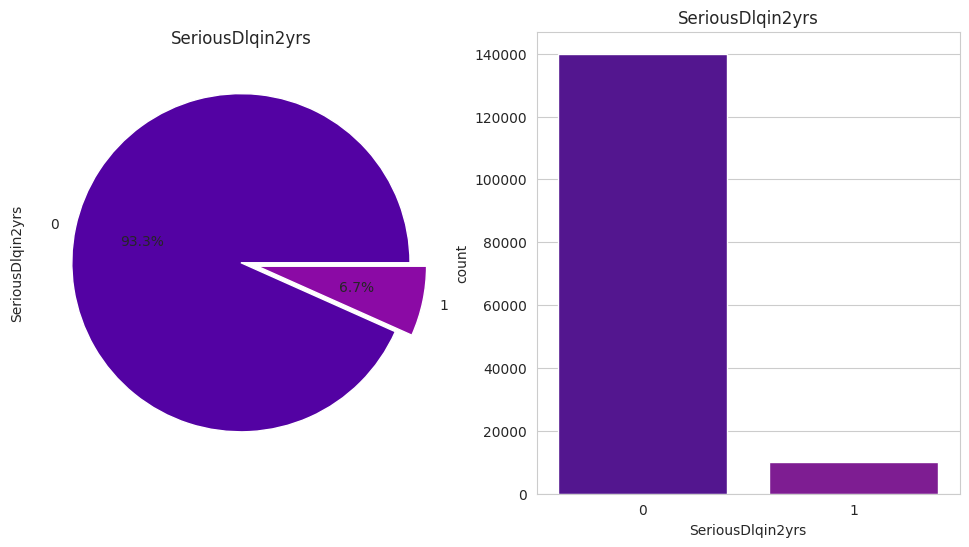

In [12]:
fig, axes = plt.subplots(1,2,figsize=(12,6))

df_train['SeriousDlqin2yrs'].value_counts().plot.pie(explode=[0,0.1], autopct='%1.1f%%',ax=axes[0])
axes[0].set_title('SeriousDlqin2yrs')

sns.countplot(x='SeriousDlqin2yrs', data=df_train, ax=axes[1])
axes[1].set_title('SeriousDlqin2yrs')

plt.show()

In [147]:
# Assuming train and test are dataframes
# Add a column to each indicating their origin

df_train['dataset'] = 'train'
df_test['dataset'] = 'test'

# Concatenate the two dataframes
combined_data = pd.concat([df_train, df_test], ignore_index=True)

In [14]:
print('Combined data shape: ', combined_data.shape)

Combined data shape:  (251503, 13)


In [15]:
# check if exist any duplicated data
print(combined_data.duplicated().value_counts())

False    251503
dtype: int64


In [148]:
# # Calculate the correlation matrix
# correlation_matrix = combined_data.corr()

# # Print the correlation matrix
# print(correlation_matrix.to_string())
combined_data.corr()

<ipython-input-148-13405f3bbb0b>:6: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  combined_data.corr()


,ID,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
ID,1.00,0.00,0.00,0.00,-0.00,-0.00,-0.00,0.00,-0.00,0.00,-0.00,-0.00
SeriousDlqin2yrs,0.00,1.00,-0.00,-0.12,0.13,-0.01,-0.02,-0.03,0.12,-0.01,0.10,0.05
RevolvingUtilizationOfUnsecuredLines,0.00,-0.00,1.00,-0.01,-0.00,0.00,0.00,-0.01,-0.00,0.01,-0.00,0.00
age,0.00,-0.12,-0.01,1.00,-0.07,0.03,0.03,0.15,-0.06,0.03,-0.06,-0.21
NumberOfTime30-59DaysPastDueNotWorse,-0.00,0.13,-0.00,-0.07,1.00,-0.01,-0.01,-0.06,0.98,-0.03,0.99,-0.00
DebtRatio,-0.00,-0.01,0.00,0.03,-0.01,1.00,-0.01,0.05,-0.01,0.12,-0.01,-0.04
MonthlyIncome,-0.00,-0.02,0.00,0.03,-0.01,-0.01,1.00,0.05,-0.01,0.07,-0.01,0.03
NumberOfOpenCreditLinesAndLoans,0.00,-0.03,-0.01,0.15,-0.06,0.05,0.05,1.00,-0.08,0.43,-0.07,0.07
NumberOfTimes90DaysLate,-0.00,0.12,-0.00,-0.06,0.98,-0.01,-0.01,-0.08,1.00,-0.05,0.99,-0.01
NumberRealEstateLoansOrLines,0.00,-0.01,0.01,0.03,-0.03,0.12,0.07,0.43,-0.05,1.00,-0.04,0.12


* High correlation between NumberOfTime30-59DaysPastDueNotWorse, NumberOfTime60-89DaysPastDueNotWorse and NumberOfTime90DaysLate.

* A correlation between NumberOfOpenCreditLinesAndLoans and NumberRealEstateLoansOrLines.

* A correlation between NumberOfDependents and Age.

### RevolvingUtilizationOfUnsecuredLines Column

In [16]:
combined_data[["RevolvingUtilizationOfUnsecuredLines"]].describe()

,RevolvingUtilizationOfUnsecuredLines
count,"251,503.00"
mean,5.75
std,229.63
min,0.00
25%,0.03
50%,0.15
75%,0.56
max,"50,708.00"


In [17]:
prt_corr(combined_data,'RevolvingUtilizationOfUnsecuredLines', 'SeriousDlqin2yrs')

Correlation between RevolvingUtilizationOfUnsecuredLines and SeriousDlqin2yrs: -0.0018015025039439683


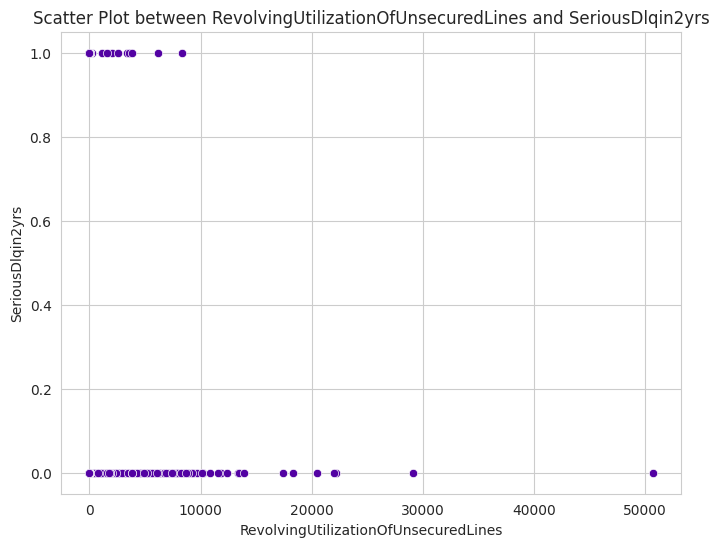

In [18]:
scatter_plot(combined_data,'RevolvingUtilizationOfUnsecuredLines', 'SeriousDlqin2yrs')

In [19]:
print("Number of RevolvingUtilizationOfUnsecuredLines that are more than 1:", len(combined_data[combined_data['RevolvingUtilizationOfUnsecuredLines'] > 1]))

Number of RevolvingUtilizationOfUnsecuredLines that are more than 1: 5502


In [149]:
combined_data['RevolvingUtilizationOfUnsecuredLines'] = combined_data['RevolvingUtilizationOfUnsecuredLines'].apply(lambda x: 1 if x > 1 else x)

combined_data[['RevolvingUtilizationOfUnsecuredLines']].describe()

,RevolvingUtilizationOfUnsecuredLines
count,"251,503.00"
mean,0.32
std,0.35
min,0.00
25%,0.03
50%,0.15
75%,0.56
max,1.00


In [61]:
prt_corr(combined_data,'RevolvingUtilizationOfUnsecuredLines', 'SeriousDlqin2yrs')

Correlation between RevolvingUtilizationOfUnsecuredLines and SeriousDlqin2yrs: 0.27809636823708855


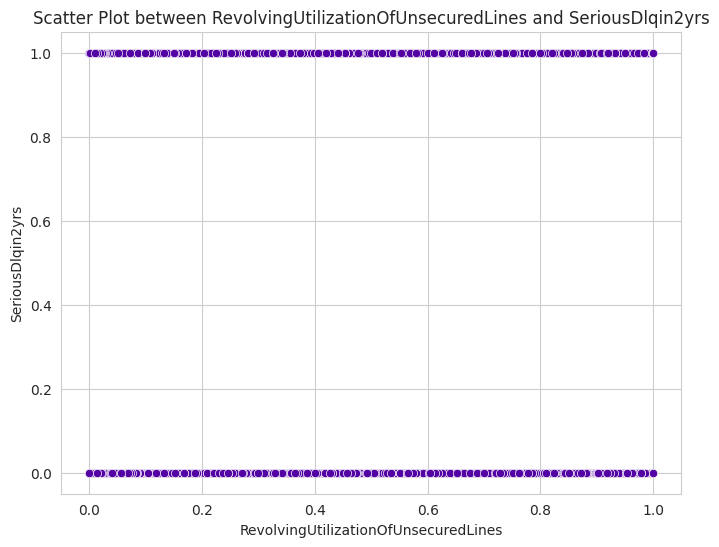

In [62]:
scatter_plot(combined_data,'RevolvingUtilizationOfUnsecuredLines', 'SeriousDlqin2yrs')

In [68]:
woe_iv_result = calculate_woe_iv(combined_data, 'SeriousDlqin2yrs', 'RevolvingUtilizationOfUnsecuredLines', bins=10)
print(woe_iv_result)

Information Value (IV) for RevolvingUtilizationOfUnsecuredLines: 1.113179949036171
      binned_feature   woe   iv  count
0  (-0.001, 0.00299] -1.02 0.07  15016
1  (0.00299, 0.0192] -1.65 0.14  14999
2   (0.0192, 0.0435] -1.62 0.14  14988
3    (0.0435, 0.083] -1.30 0.10  14944
4     (0.083, 0.154] -1.08 0.07  14938
5     (0.154, 0.271] -0.69 0.04  15094
6     (0.271, 0.446] -0.26 0.01  15113
7     (0.446, 0.702]  0.31 0.01  15065
8     (0.702, 0.982]  1.03 0.16  14904
9       (0.982, 1.0]  1.44 0.38  14939


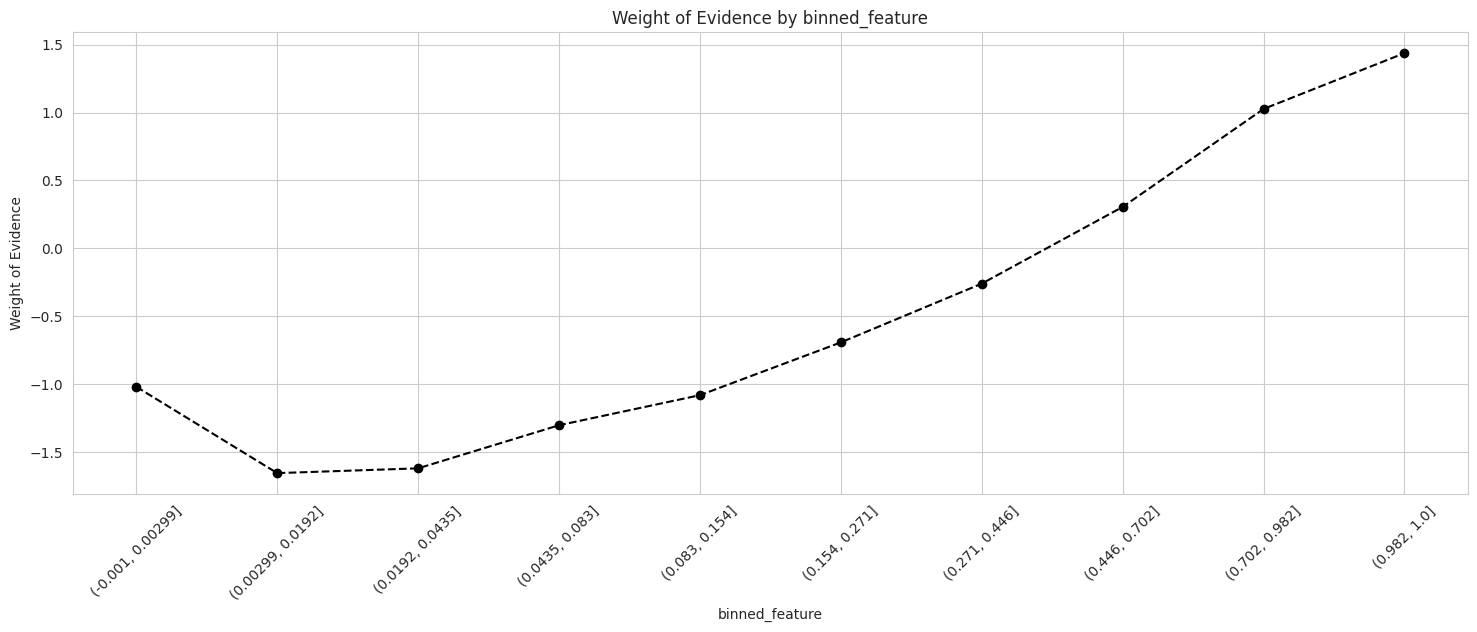

In [69]:
plot_woe(woe_iv_result, 45)

In [150]:
combined_data['RevolvingUtilizationOfUnsecuredLines: < 0.003'] = np.where((combined_data['RevolvingUtilizationOfUnsecuredLines'] <= 0.003), 1, 0)

combined_data['RevolvingUtilizationOfUnsecuredLines: 0.003 - 0.0435'] = np.where((combined_data['RevolvingUtilizationOfUnsecuredLines'] > 0.003) &
                                                                          (combined_data['RevolvingUtilizationOfUnsecuredLines'] <= 0.0435), 1, 0)

combined_data['RevolvingUtilizationOfUnsecuredLines: 0.0435 - 0.154'] = np.where((combined_data['RevolvingUtilizationOfUnsecuredLines'] > 0.0435) &
                                                                          (combined_data['RevolvingUtilizationOfUnsecuredLines'] <= 0.154), 1, 0)

combined_data['RevolvingUtilizationOfUnsecuredLines: 0.154 - 0.271'] = np.where((combined_data['RevolvingUtilizationOfUnsecuredLines'] > 0.154) &
                                                                          (combined_data['RevolvingUtilizationOfUnsecuredLines'] <= 0.271), 1, 0)

combined_data['RevolvingUtilizationOfUnsecuredLines: 0.271 - 0.446'] = np.where((combined_data['RevolvingUtilizationOfUnsecuredLines'] > 0.271) &
                                                                          (combined_data['RevolvingUtilizationOfUnsecuredLines'] <= 0.446), 1, 0)

combined_data['RevolvingUtilizationOfUnsecuredLines: 0.446 - 0.702'] = np.where((combined_data['RevolvingUtilizationOfUnsecuredLines'] > 0.446) &
                                                                          (combined_data['RevolvingUtilizationOfUnsecuredLines'] <= 0.702), 1, 0)

combined_data['RevolvingUtilizationOfUnsecuredLines: > 0.702'] = np.where((combined_data['RevolvingUtilizationOfUnsecuredLines'] > 0.702), 1, 0)

### Age Column

In [71]:
combined_data[["age"]].describe()

,age
count,"251,503.00"
mean,52.34
std,14.78
min,0.00
25%,41.00
50%,52.00
75%,63.00
max,109.00


In [72]:
zero_age_count = (combined_data['age'] == 0).sum()
print(f"Number of values equal to zero in the 'age' column: {zero_age_count}")

Number of values equal to zero in the 'age' column: 1


In [151]:
# Impute age=0 with the median age
median_age = combined_data['age'].median()
combined_data['age'] = combined_data['age'].replace(0, median_age)

In [74]:
prt_corr(combined_data, 'age', 'SeriousDlqin2yrs')

Correlation between age and SeriousDlqin2yrs: -0.11539662019283052


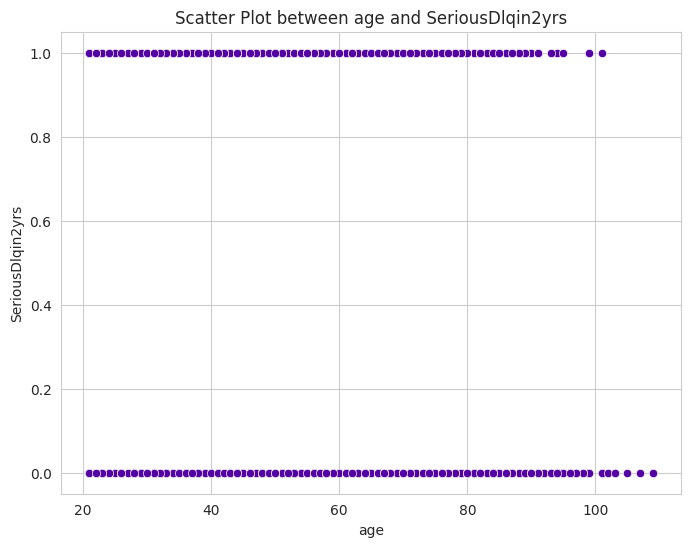

In [75]:
scatter_plot(combined_data, 'age', 'SeriousDlqin2yrs')

In [84]:
woe_iv_result = calculate_woe_iv(combined_data, 'SeriousDlqin2yrs', 'age', bins=20)
print(woe_iv_result)

Information Value (IV) for age: 0.26200481206952064
    binned_feature   woe   iv  count
0   (20.999, 29.0]  0.62 0.03   8820
1     (29.0, 33.0]  0.54 0.02   8264
2     (33.0, 36.0]  0.46 0.01   6780
3     (36.0, 39.0]  0.34 0.01   8139
4     (39.0, 41.0]  0.32 0.00   6215
5     (41.0, 44.0]  0.25 0.00   9584
6     (44.0, 46.0]  0.25 0.00   7216
7     (46.0, 48.0]  0.18 0.00   7525
8     (48.0, 50.0]  0.17 0.00   7590
9     (50.0, 52.0]  0.14 0.00   7237
10    (52.0, 54.0]  0.06 0.00   7209
11    (54.0, 56.0] -0.10 0.00   7005
12    (56.0, 58.0] -0.29 0.00   6818
13    (58.0, 61.0] -0.33 0.01  10060
14    (61.0, 63.0] -0.52 0.01   7287
15    (63.0, 65.0] -0.74 0.02   5652
16    (65.0, 68.0] -0.90 0.03   7232
17    (68.0, 72.0] -1.03 0.03   7026
18    (72.0, 78.0] -1.14 0.04   7548
19   (78.0, 109.0] -1.22 0.04   6793


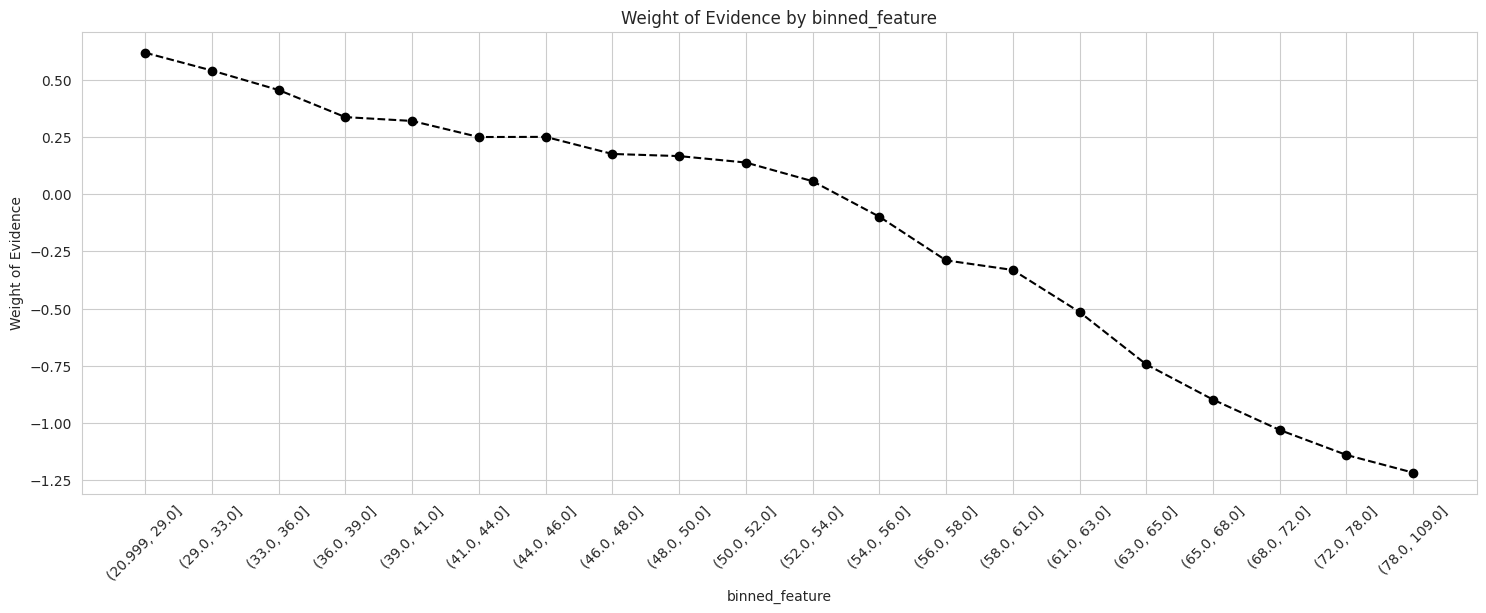

In [85]:
plot_woe(woe_iv_result, 45)

In [152]:
combined_data['ages: < 33'] = np.where((combined_data['age'] <= 33), 1, 0)

combined_data['age: 33 - 46'] = np.where((combined_data['age'] > 33) & (combined_data['age'] <= 46), 1, 0)

combined_data['age: 46 - 54'] = np.where((combined_data['age'] > 46) & (combined_data['age'] <= 54), 1, 0)

combined_data['age: 54 - 63'] = np.where((combined_data['age'] > 54) & (combined_data['age'] <= 63), 1, 0)

combined_data['age: 63 - 72'] = np.where((combined_data['age'] > 63) & (combined_data['age'] <= 72), 1, 0)

combined_data['age: > 72'] = np.where((combined_data['age'] > 72), 1, 0)

### Overdue Payment Indicators

* `NumberOfTimes90DaysLate`
* `NumberOfTime60-89DaysPastDueNotWorse`
* `NumberOfTime30-59DaysPastDueNotWorse`

In [100]:
late_pay_cols = ["NumberOfTime30-59DaysPastDueNotWorse", "NumberOfTime60-89DaysPastDueNotWorse", "NumberOfTimes90DaysLate"]
combined_data[late_pay_cols].describe([0.25, 0.5, 0.75, 0.8, 0.85, 0.90, 0.95, 0.99])

,NumberOfTime30-59DaysPastDueNotWorse,NumberOfTime60-89DaysPastDueNotWorse,NumberOfTimes90DaysLate
count,"251,503.00","251,503.00","251,503.00"
mean,0.43,0.25,0.28
std,4.34,4.30,4.31
min,0.00,0.00,0.00
25%,0.00,0.00,0.00
50%,0.00,0.00,0.00
75%,0.00,0.00,0.00
80%,0.00,0.00,0.00
85%,1.00,0.00,0.00
90%,1.00,0.00,0.00


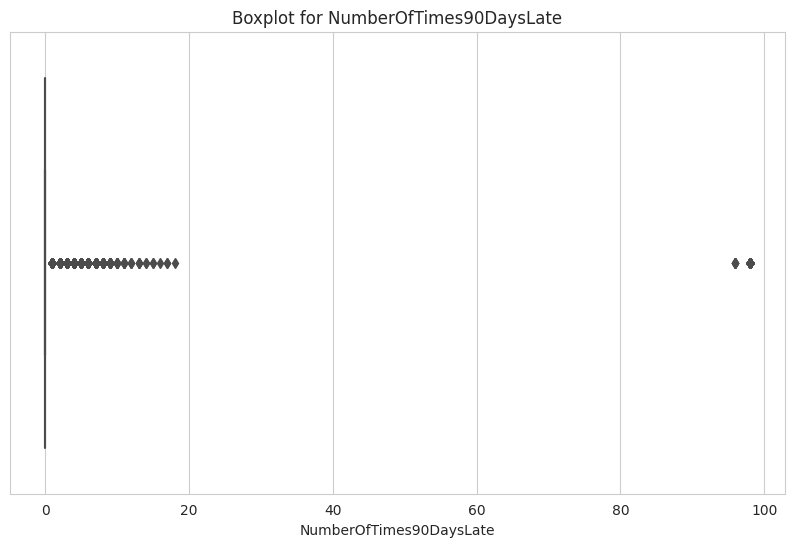

In [101]:
box_plot(combined_data, 'NumberOfTimes90DaysLate')

In [102]:
# Create three tables
count_90_days = combined_data["NumberOfTimes90DaysLate"].value_counts().sort_index()
count_60_89_days = combined_data["NumberOfTime60-89DaysPastDueNotWorse"].value_counts().sort_index()
count_30_59_days = combined_data["NumberOfTime30-59DaysPastDueNotWorse"].value_counts().sort_index()

# Concatenate the value counts into a single DataFrame
result_df = pd.concat([count_90_days, count_60_89_days, count_30_59_days], axis=1)

# Rename the columns for clarity
result_df.columns = ['NumberOfTimes90DaysLate', 'NumberOfTime60-89DaysPastDueNotWorse', 'NumberOfTime30-59DaysPastDueNotWorse']

# Display the resulting DataFrame
print(result_df.to_string())

    NumberOfTimes90DaysLate  NumberOfTime60-89DaysPastDueNotWorse  NumberOfTime30-59DaysPastDueNotWorse
0                237,447.00                            238,771.00                            211,208.00
1                  8,837.00                              9,594.00                             26,870.00
2                  2,617.00                              1,849.00                              7,766.00
3                  1,112.00                                534.00                              2,955.00
4                    482.00                                166.00                              1,257.00
5                    233.00                                 59.00                                547.00
6                    124.00                                 23.00                                228.00
7                     64.00                                 16.00                                 96.00
8                     40.00                                  3.0

In [103]:
# Calculate the correlation
df_corr = combined_data[["NumberOfTime30-59DaysPastDueNotWorse", "NumberOfTime60-89DaysPastDueNotWorse", "NumberOfTimes90DaysLate", "SeriousDlqin2yrs"]]

# Calculate the correlation matrix
correlation_matrix = df_corr.corr()

# Print the correlation matrix
print(correlation_matrix.to_string())

                                      NumberOfTime30-59DaysPastDueNotWorse  NumberOfTime60-89DaysPastDueNotWorse  NumberOfTimes90DaysLate  SeriousDlqin2yrs
NumberOfTime30-59DaysPastDueNotWorse                                  1.00                                  0.99                     0.98              0.13
NumberOfTime60-89DaysPastDueNotWorse                                  0.99                                  1.00                     0.99              0.10
NumberOfTimes90DaysLate                                               0.98                                  0.99                     1.00              0.12
SeriousDlqin2yrs                                                      0.13                                  0.10                     0.12              1.00


In [153]:
# Set upper bound
def upper_bound(col):
  upper_bound = combined_data[col].quantile(0.99)
  # Apply winsorizing using .loc[]
  combined_data.loc[combined_data[col] > upper_bound, col] = upper_bound

upper_bound('NumberOfTime30-59DaysPastDueNotWorse')
upper_bound('NumberOfTime60-89DaysPastDueNotWorse')
upper_bound('NumberOfTimes90DaysLate')

In [105]:
# Calculate the correlation
df_corr = combined_data[["NumberOfTime30-59DaysPastDueNotWorse", "NumberOfTime60-89DaysPastDueNotWorse", "NumberOfTimes90DaysLate", "SeriousDlqin2yrs"]]

# Calculate the correlation matrix
correlation_matrix = df_corr.corr()

# Print the correlation matrix
print(correlation_matrix.to_string())

                                      NumberOfTime30-59DaysPastDueNotWorse  NumberOfTime60-89DaysPastDueNotWorse  NumberOfTimes90DaysLate  SeriousDlqin2yrs
NumberOfTime30-59DaysPastDueNotWorse                                  1.00                                  0.36                     0.30              0.29
NumberOfTime60-89DaysPastDueNotWorse                                  0.36                                  1.00                     0.38              0.29
NumberOfTimes90DaysLate                                               0.30                                  0.38                     1.00              0.35
SeriousDlqin2yrs                                                      0.29                                  0.29                     0.35              1.00


In [154]:
# Coefficients for weighting
coefficients = {
    'NumberOfTime30-59DaysPastDueNotWorse': 1,
    'NumberOfTime60-89DaysPastDueNotWorse': 2,
    'NumberOfTimes90DaysLate': 3
}

# Create the weighted average column
combined_data['OverduePaymentIndicatorsWeightedAverage'] = (
    combined_data['NumberOfTime30-59DaysPastDueNotWorse'] * coefficients['NumberOfTime30-59DaysPastDueNotWorse'] +
    combined_data['NumberOfTime60-89DaysPastDueNotWorse'] * coefficients['NumberOfTime60-89DaysPastDueNotWorse'] +
    combined_data['NumberOfTimes90DaysLate'] * coefficients['NumberOfTimes90DaysLate']
) / sum(coefficients.values())

In [155]:
from sklearn.decomposition import PCA

pca = PCA(n_components=1)
combined_data['OverduePaymentIndicatorsPCA'] = pca.fit_transform(combined_data[['NumberOfTime30-59DaysPastDueNotWorse', 'NumberOfTime60-89DaysPastDueNotWorse', 'NumberOfTimes90DaysLate']])


In [156]:
prt_corr(combined_data, 'OverduePaymentIndicatorsWeightedAverage', 'SeriousDlqin2yrs')

Correlation between OverduePaymentIndicatorsWeightedAverage and SeriousDlqin2yrs: 0.41473347921069065


In [157]:
prt_corr(combined_data, 'OverduePaymentIndicatorsPCA', 'SeriousDlqin2yrs')

Correlation between OverduePaymentIndicatorsPCA and SeriousDlqin2yrs: 0.33805779917564843


In [158]:
combined_data = combined_data.drop(['NumberOfTime30-59DaysPastDueNotWorse', 'NumberOfTimes90DaysLate',
                   'NumberOfTime60-89DaysPastDueNotWorse', 'OverduePaymentIndicatorsPCA'],axis=1)

### DebtRatio

In [113]:
combined_data[["DebtRatio"]].describe()

,DebtRatio
count,"251,503.00"
mean,349.56
std,"1,884.79"
min,0.00
25%,0.17
50%,0.37
75%,0.86
max,"329,664.00"


**Minimum (min):** The minimum DebtRatio is 0. This suggests that there are entries where the debt payments, alimony, and living costs are effectively zero or extremely low compared to the gross income percentage.

**Maximum (max):** The maximum DebtRatio is very high at 329,664. This suggests the presence of outliers in the data.

In [114]:
pd.concat([combined_data.loc[combined_data["DebtRatio"] == 0][["MonthlyIncome"]].describe().rename(columns={"MonthlyIncome": "MonthlyIncome (DebtRatio = 0)"}), combined_data[["MonthlyIncome"]].describe()], axis=1)

,MonthlyIncome (DebtRatio = 0),MonthlyIncome
count,"4,143.00","201,669.00"
mean,"4,154.11","6,744.82"
std,"12,338.29","25,717.61"
min,0.00,0.00
25%,"1,630.50","3,400.00"
50%,"3,000.00","5,400.00"
75%,"5,000.00","8,212.00"
max,"629,000.00","7,727,000.00"


Given that 75% of the entries with `DebtRatio` equal to 0 have a `MonthlyIncome` below 5,000, it suggests that the value 0 for `DebtRatio` may be inaccurate or missing data.

**For handling this situation:**

Imputation: If the `DebtRatio` being 0 is likely a mistake, you could consider imputing values based on the distribution of `DebtRatio` for other entries with similar income levels.

In [115]:
combined_data.loc[(combined_data["MonthlyIncome"] < 5000) & ~(combined_data["DebtRatio"] == 0)][["DebtRatio"]].describe()

,DebtRatio
count,"85,883.00"
mean,64.15
std,"1,022.45"
min,0.00
25%,0.14
50%,0.34
75%,0.63
max,"202,990.00"


In [116]:
# Set this value for all data that DetRatio is zero.
combined_data.loc[(combined_data["MonthlyIncome"] < 5000) & ~(combined_data["DebtRatio"] == 0) ]["DebtRatio"].quantile(0.5)

0.340855419

In [117]:
# count of DebtRatio more than 1.
len(combined_data[(combined_data["DebtRatio"] > 1)])

58715

In [118]:
prt_corr(combined_data, 'DebtRatio', 'SeriousDlqin2yrs')

Correlation between DebtRatio and SeriousDlqin2yrs: -0.00760211982645619


In [159]:
# Set lower bound for DebtRatio is zero and upper bound for DebtRatio more than 1
upper_bound = 1
lower_bound = combined_data.loc[(combined_data["MonthlyIncome"] < 5000) & ~(combined_data["DebtRatio"] == 0) ]["DebtRatio"].quantile(0.5)

# Apply winsorizing using .loc[]
combined_data.loc[combined_data['DebtRatio'] > upper_bound, 'DebtRatio'] = upper_bound
combined_data.loc[combined_data['DebtRatio'] == 0, 'DebtRatio'] = lower_bound

In [120]:
prt_corr(combined_data, 'DebtRatio', 'SeriousDlqin2yrs')

Correlation between DebtRatio and SeriousDlqin2yrs: 0.02539309423968273


In [121]:
combined_data[["DebtRatio"]].describe()

,DebtRatio
count,"251,503.00"
mean,0.47
std,0.35
min,0.00
25%,0.20
50%,0.37
75%,0.86
max,1.00


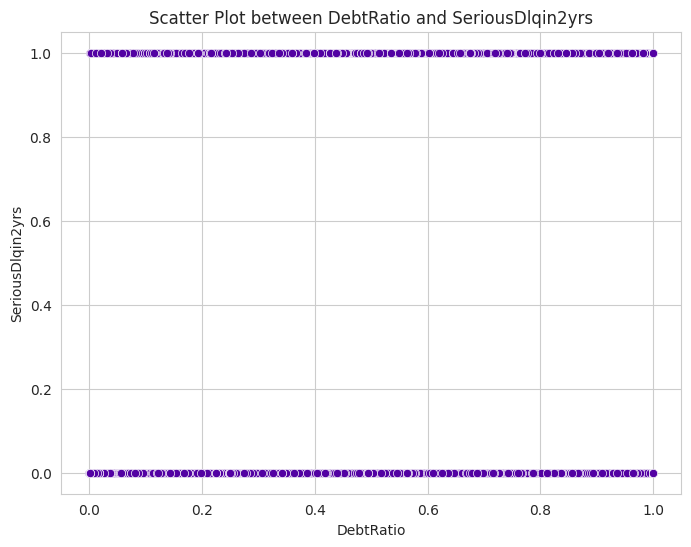

In [122]:
scatter_plot(combined_data, 'DebtRatio', 'SeriousDlqin2yrs')

In [126]:
woe_iv_result = calculate_woe_iv(combined_data, 'SeriousDlqin2yrs', 'DebtRatio', bins=20)
print(woe_iv_result)

Information Value (IV) for DebtRatio: 0.05126499914068982
          binned_feature   woe   iv  count
0   (-0.0009898, 0.0133] -0.69 0.02   7493
1       (0.0133, 0.0629] -0.01 0.00   7478
2        (0.0629, 0.113]  0.02 0.00   7450
3         (0.113, 0.156] -0.06 0.00   7457
4         (0.156, 0.196] -0.10 0.00   7491
5         (0.196, 0.233] -0.17 0.00   7478
6          (0.233, 0.27] -0.28 0.00   7566
7          (0.27, 0.307] -0.23 0.00   7463
8         (0.307, 0.341] -0.01 0.00  10503
9         (0.341, 0.366] -0.09 0.00   4472
10        (0.366, 0.412] -0.05 0.00   7495
11        (0.412, 0.466]  0.07 0.00   7518
12        (0.466, 0.538]  0.15 0.00   7542
13        (0.538, 0.645]  0.34 0.01   7399
14        (0.645, 0.862]  0.52 0.02   7547
15          (0.862, 1.0]  0.02 0.00  37648


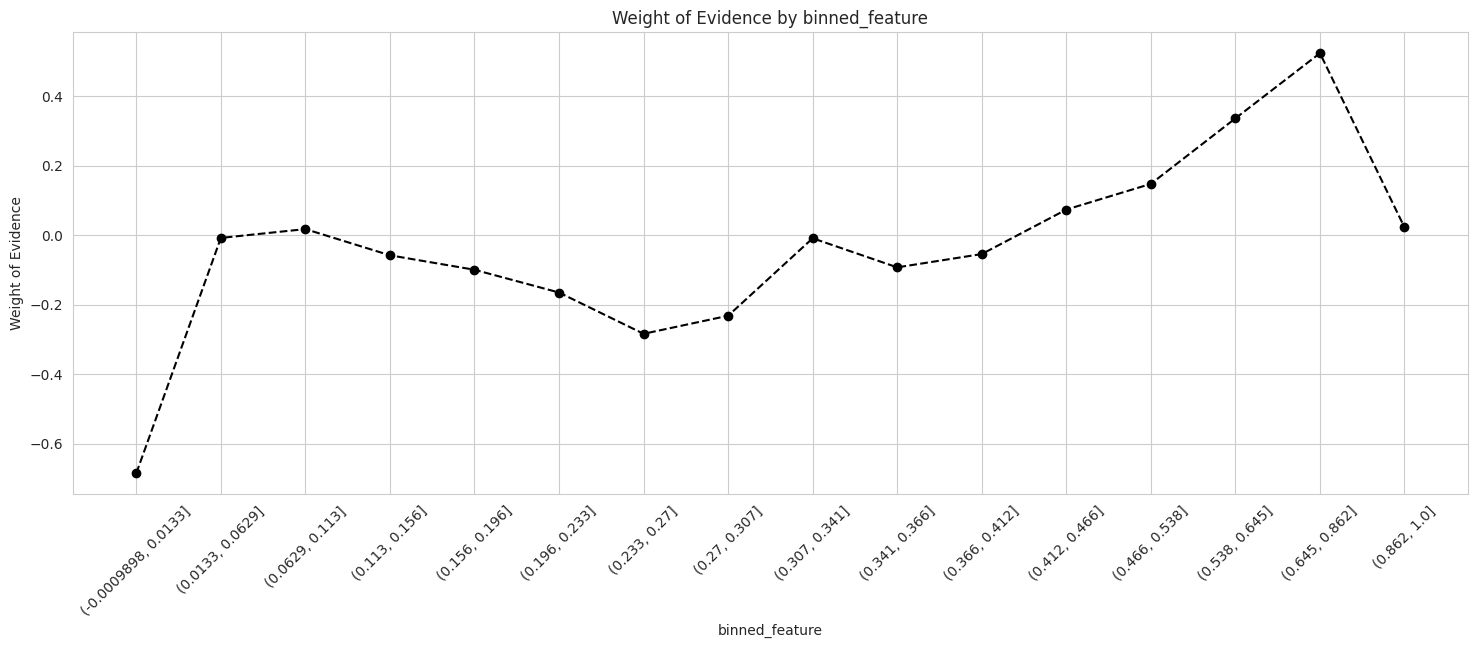

In [127]:
plot_woe(woe_iv_result, 45)

In [160]:
combined_data['DebtRatio: < 0.063'] = np.where((combined_data['DebtRatio'] <= 0.063), 1, 0)

combined_data['DebtRatio: 0.063 - 0.233'] = np.where((combined_data['DebtRatio'] > 0.063) & (combined_data['DebtRatio'] <= 0.233), 1, 0)

combined_data['DebtRatio: 0.233 - 0.307'] = np.where((combined_data['DebtRatio'] > 0.233) & (combined_data['DebtRatio'] <= 0.307), 1, 0)

combined_data['DebtRatio: 0.307 - 0.412'] = np.where((combined_data['DebtRatio'] > 0.307) & (combined_data['DebtRatio'] <= 0.412), 1, 0)

combined_data['DebtRatio: 0.412 - 0.645'] = np.where((combined_data['DebtRatio'] > 0.412) & (combined_data['DebtRatio'] <= 0.645), 1, 0)

combined_data['DebtRatio: 0.645 - 0.862'] = np.where((combined_data['DebtRatio'] > 0.645) & (combined_data['DebtRatio'] <= 0.862), 1, 0)

combined_data['DebtRatio: > 0.862'] = np.where((combined_data['DebtRatio'] > 0.862), 1, 0)

### NumberOfOpenCreditLinesAndLoans Column

In [172]:
combined_data[["NumberOfOpenCreditLinesAndLoans"]].describe([0.1, 0.25, 0.5, 0.75, 0.85, 0.9, 0.95])

,NumberOfOpenCreditLinesAndLoans
count,"251,503.00"
mean,8.45
std,5.15
min,0.00
10%,3.00
25%,5.00
50%,8.00
75%,11.00
85%,13.00
90%,15.00


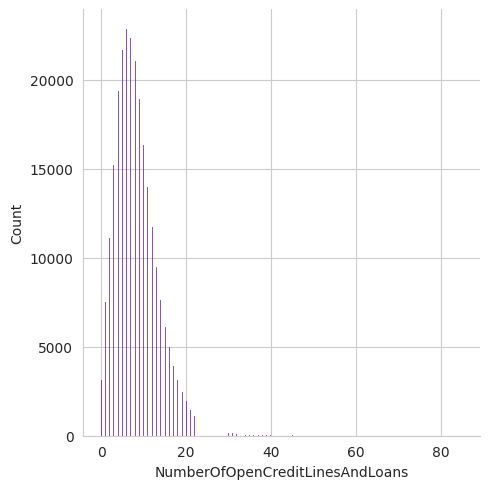

In [173]:
sns.displot(combined_data["NumberOfOpenCreditLinesAndLoans"])

In [174]:
prt_corr(combined_data, 'NumberOfOpenCreditLinesAndLoans', 'SeriousDlqin2yrs')

Correlation between NumberOfOpenCreditLinesAndLoans and SeriousDlqin2yrs: -0.029668568469318504


In [192]:
upper_bound = combined_data["NumberOfOpenCreditLinesAndLoans"].quantile(0.75)

# Apply winsorizing using .loc[]
combined_data.loc[combined_data['NumberOfOpenCreditLinesAndLoans'] > upper_bound, 'NumberOfOpenCreditLinesAndLoans'] = upper_bound

In [193]:
prt_corr(combined_data, 'NumberOfOpenCreditLinesAndLoans', 'SeriousDlqin2yrs')

Correlation between NumberOfOpenCreditLinesAndLoans and SeriousDlqin2yrs: -0.050748144856402624


### NumberRealEstateLoansOrLines Column

In [161]:
combined_data[["NumberRealEstateLoansOrLines"]].describe([0.25, 0.5, 0.75, 0.8, 0.9, 0.95])

,NumberRealEstateLoansOrLines
count,"251,503.00"
mean,1.02
std,1.12
min,0.00
25%,0.00
50%,1.00
75%,2.00
80%,2.00
90%,2.00
95%,3.00


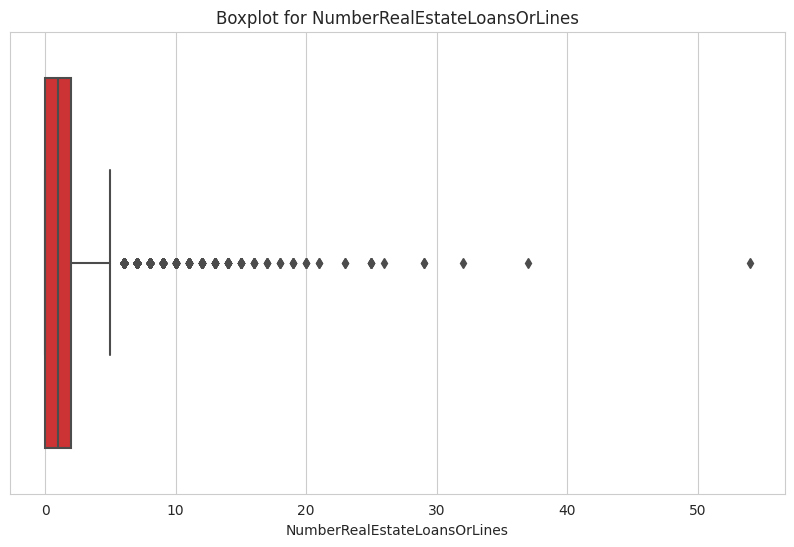

In [162]:
box_plot(combined_data, 'NumberRealEstateLoansOrLines')

In [163]:
prt_corr(combined_data, 'NumberRealEstateLoansOrLines', 'SeriousDlqin2yrs')

Correlation between NumberRealEstateLoansOrLines and SeriousDlqin2yrs: -0.00703811633598353


In [194]:
upper_bound = combined_data["NumberRealEstateLoansOrLines"].quantile(0.75)

# Apply winsorizing using .loc[]
combined_data.loc[combined_data['NumberRealEstateLoansOrLines'] > upper_bound, 'NumberRealEstateLoansOrLines'] = upper_bound

In [195]:
prt_corr(combined_data, 'NumberRealEstateLoansOrLines', 'SeriousDlqin2yrs')

Correlation between NumberRealEstateLoansOrLines and SeriousDlqin2yrs: -0.0360796962678082


Making a **new feature** for combining `NumberOfOpenCreditLinesAndLoans` and `NumberRealEstateLoansOrLines`.

In [197]:
prt_corr(combined_data, 'NumberOfOpenCreditLinesAndLoans', 'NumberRealEstateLoansOrLines')

Correlation between NumberOfOpenCreditLinesAndLoans and NumberRealEstateLoansOrLines: 0.4680628063223541


In [223]:
from sklearn.preprocessing import MinMaxScaler

feature_columns = ['NumberOfOpenCreditLinesAndLoans', 'NumberRealEstateLoansOrLines']

# Standardize the features
scaler = MinMaxScaler()
standardized_features = pd.DataFrame(scaler.fit_transform(combined_data[feature_columns]), columns=feature_columns)

# Adjust weights based on preference
weights = [0.3, 0.7]

# Create new composite feature using weighted average and add it to 'combined_data'
combined_data['NumberOfLoanWeightedAverage'] = standardized_features['NumberOfOpenCreditLinesAndLoans'] * weights[0] + standardized_features['NumberRealEstateLoansOrLines'] * weights[1]


In [225]:
prt_corr(combined_data, 'NumberOfLoanWeightedAverage', 'SeriousDlqin2yrs')

Correlation between NumberOfLoanWeightedAverage and SeriousDlqin2yrs: -0.04404583362905949


In [226]:
combined_data['NumberOfLoanWeightedAverage'].describe()

count   251,503.00
mean          0.52
std           0.33
min           0.00
25%           0.19
50%           0.54
75%           0.86
max           1.00
Name: NumberOfLoanWeightedAverage, dtype: float64

In [229]:
woe_iv_result = calculate_woe_iv(combined_data, 'SeriousDlqin2yrs', 'NumberOfLoanWeightedAverage', bins=20)
print(woe_iv_result)

Information Value (IV) for NumberOfLoanWeightedAverage: 0.09665494489265658
      binned_feature   woe   iv  count
0   (-0.001, 0.0545]  0.73 0.06  11564
1   (0.0545, 0.0818]  0.17 0.00   6162
2    (0.0818, 0.109]  0.06 0.00   6587
3     (0.109, 0.136]  0.10 0.00   6059
4     (0.136, 0.191]  0.04 0.00   9842
5     (0.191, 0.245] -0.02 0.00   6548
6       (0.245, 0.3]  0.07 0.00   9426
7       (0.3, 0.432]  0.30 0.00   3871
8     (0.432, 0.486] -0.28 0.00   8863
9     (0.486, 0.541] -0.38 0.01  10854
10    (0.541, 0.568] -0.47 0.01   5170
11    (0.568, 0.623] -0.32 0.00   8377
12     (0.623, 0.65] -0.25 0.01  15203
13     (0.65, 0.864] -0.16 0.00   6252
14    (0.864, 0.918] -0.31 0.00   7131
15    (0.918, 0.973] -0.11 0.00   7469
16      (0.973, 1.0]  0.05 0.00  20622


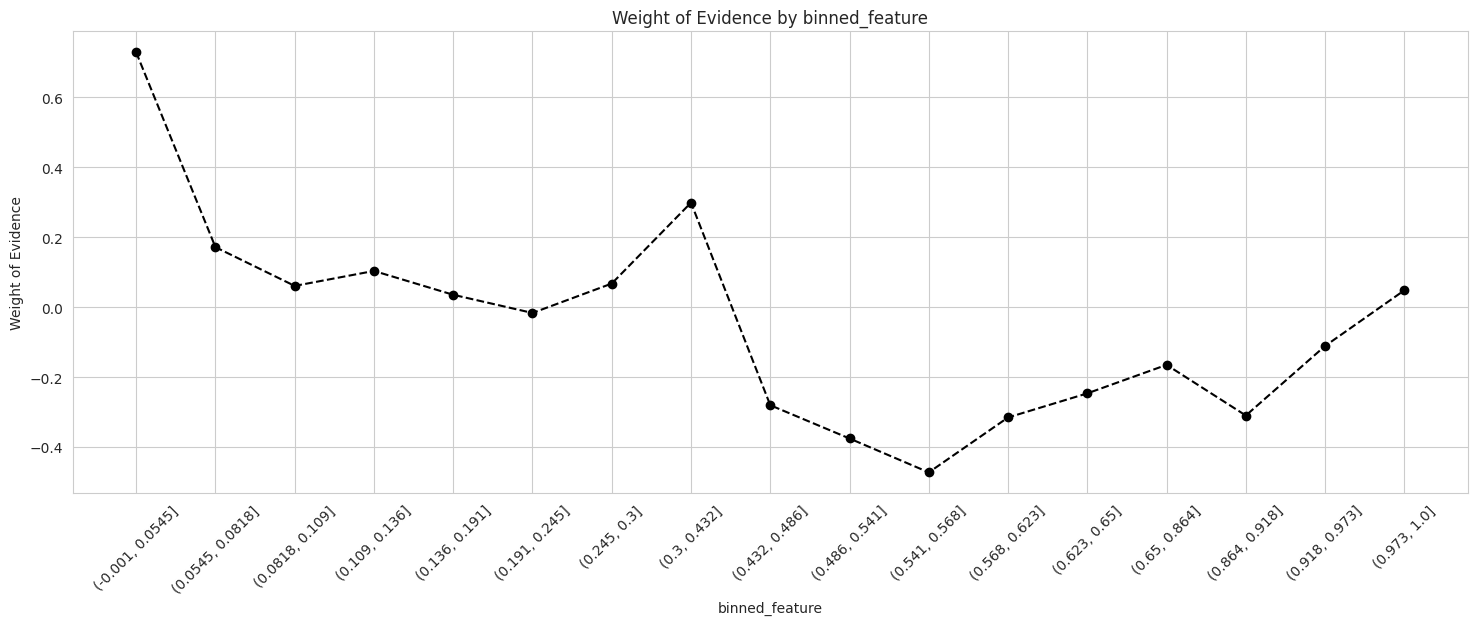

In [230]:
plot_woe(woe_iv_result, 45)

In [231]:
combined_data['NumberOfLoanWeightedAverage < 0.05'] = np.where((combined_data['NumberOfLoanWeightedAverage'] <= 0.05), 1, 0)

combined_data['NumberOfLoanWeightedAverage: 0.05 - 0.3'] = np.where((combined_data['NumberOfLoanWeightedAverage'] > 0.05) & (combined_data['NumberOfLoanWeightedAverage'] <= 0.3), 1, 0)

combined_data['NumberOfLoanWeightedAverage: 0.3 - 0.432'] = np.where((combined_data['NumberOfLoanWeightedAverage'] > 0.3) & (combined_data['NumberOfLoanWeightedAverage'] <= 0.432), 1, 0)

combined_data['NumberOfLoanWeightedAverage: 0.432 - 0.568'] = np.where((combined_data['NumberOfLoanWeightedAverage'] > 0.432) & (combined_data['NumberOfLoanWeightedAverage'] <= 0.568), 1, 0)

combined_data['NumberOfLoanWeightedAverage: 0.568 - 0.864'] = np.where((combined_data['NumberOfLoanWeightedAverage'] > 0.568) & (combined_data['NumberOfLoanWeightedAverage'] <= 0.864), 1, 0)

combined_data['NumberOfLoanWeightedAverage: > 0.864'] = np.where((combined_data['NumberOfLoanWeightedAverage'] > 0.864), 1, 0)

### NumberOfDependents Column

In [ ]:
combined_data[["NumberOfDependents"]].describe([0.25, 0.5, 0.75, 0.8, 0.9, 0.95])

,NumberOfDependents
count,"244,953.00"
mean,0.76
std,1.12
min,0.00
25%,0.00
50%,0.00
75%,1.00
80%,2.00
90%,2.00
95%,3.00


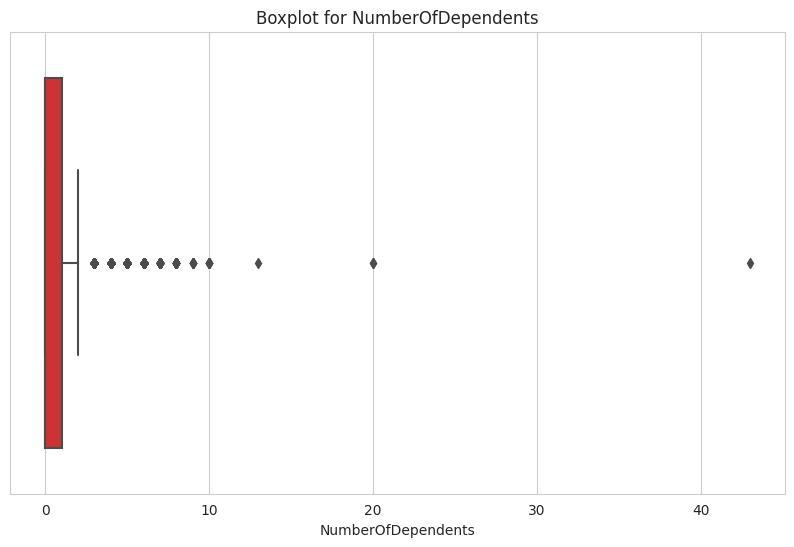

In [ ]:
box_plot(combined_data, 'NumberOfDependents')

In [ ]:
null_income_rows = combined_data['NumberOfDependents'].isnull().sum()

print("Number of rows where NumberOfDependents is NULL:", null_income_rows)

Number of rows where NumberOfDependents is NULL: 6550


In [ ]:
upper_bound = combined_data["NumberOfDependents"].quantile(0.95)

# Apply winsorizing using .loc[]
combined_data.loc[combined_data['NumberOfDependents'] > upper_bound, 'NumberOfDependents'] = upper_bound

In [ ]:
# Impute NumberOfDependents is null with the upper bound of NumberOfDependents
combined_data['NumberOfDependents'] = combined_data['NumberOfDependents'].replace(np.nan, upper_bound)

In [ ]:
prt_corr(combined_data, 'NumberOfDependents', 'SeriousDlqin2yrs')

Correlation between NumberOfDependents and SeriousDlqin2yrs: 0.03804119219113706


### ManthlyIncom Columns

In [ ]:
combined_data[["MonthlyIncome"]].describe([0.01, 0.02, 0.03, 0.05, 0.1, 0.15, 0.25, 0.5, 0.75])

,MonthlyIncome
count,"199,015.00"
mean,"6,834.76"
std,"25,876.65"
min,1.00
1%,500.00
2%,864.00
3%,"1,150.00"
5%,"1,520.00"
10%,"2,200.00"
15%,"2,657.00"


**`MonthlyIncome` column**

Handling null values in the `MonthlyIncome` column depends on the nature of your data and the impact of missing values on your analysis.

In [ ]:
null_income_rows = combined_data['MonthlyIncome'].isnull().sum()

print("Number of rows where MonthlyIncome is NULL:", null_income_rows)

Number of rows where MonthlyIncome is NULL: 49834


In [ ]:
zero_income_rows = (combined_data['MonthlyIncome'] == 0).sum()

print("Number of rows where MonthlyIncome is equal to 0:", zero_income_rows)

Number of rows where MonthlyIncome is equal to 0: 2654


Amounts less than 1000 is a little dengerous.

In [ ]:
one_income_rows = (combined_data['MonthlyIncome'] <= 1000).sum()

print("Number of rows where MonthlyIncome is equal to 1:", one_income_rows)

Number of rows where MonthlyIncome is equal to 1: 5257


Creating a binary indicator variable to denote whether "Monthly Income" was missing or very low. This way, the model can learn to distinguish cases where income information is missing or below a threshold.

In [ ]:
combined_data['LowIncomeIndicator'] = (combined_data['MonthlyIncome'] <= 1000) | (combined_data['MonthlyIncome'].isnull())

Using a predictive model to impute missing or very low values based on other features in your dataset. Train a model to predict "Monthly Income" using features that are available for those instances where income information is missing or low.

In [ ]:
from sklearn.ensemble import RandomForestRegressor

# Assuming 'features' is a list of features excluding 'MonthlyIncome'
features = ['RevolvingUtilizationOfUnsecuredLines', 'age',
            'DebtRatio', 'NumberOfOpenCreditLinesAndLoans',
            'NumberRealEstateLoansOrLines', 'NumberOfDependents',
            'OverduePaymentIndicatorsWeightedAverage', 'LowIncomeIndicator']
imputation_data = combined_data.dropna(subset=['MonthlyIncome'] + features)
model = RandomForestRegressor()
model.fit(imputation_data[features], imputation_data['MonthlyIncome'])
missing_data = combined_data[combined_data['MonthlyIncome'].isnull()]
predicted_income = model.predict(missing_data[features])
combined_data.loc[combined_data['MonthlyIncome'].isnull(), 'MonthlyIncome'] = predicted_income

In [ ]:
combined_data[["MonthlyIncome"]].describe([0.85, 0.9, 0.95, 0.999])

,MonthlyIncome
count,"251,503.00"
mean,"5,448.95"
std,"23,176.38"
min,0.00
50%,"4,361.00"
85%,"9,349.00"
90%,"10,700.00"
95%,"13,500.00"
99.9%,"75,000.00"
max,"7,727,000.00"


99.9% of Monthly Income is less than 75000.

In [ ]:
upper_bound = combined_data["MonthlyIncome"].quantile(0.9)

# Apply winsorizing using .loc[]
combined_data.loc[combined_data['MonthlyIncome'] > upper_bound, 'MonthlyIncome'] = upper_bound

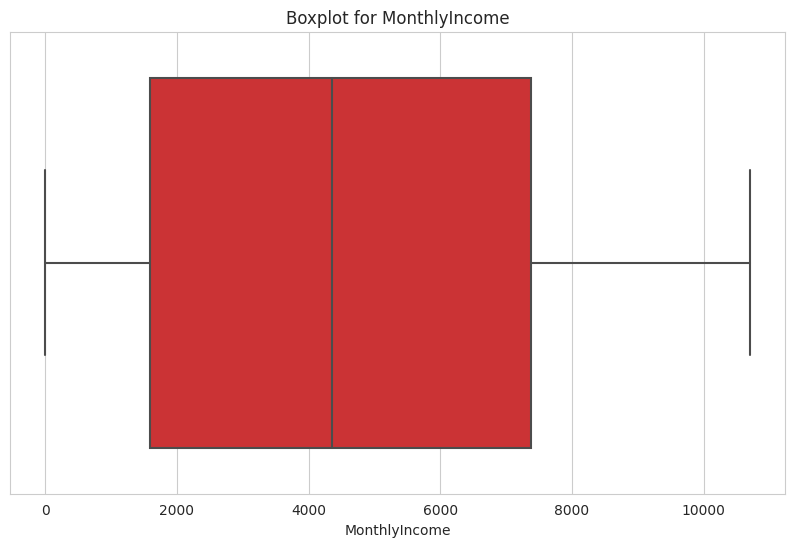

In [ ]:
box_plot(combined_data, 'MonthlyIncome')

In [ ]:
# Now you can easily separate them later
df_train = combined_data[combined_data['dataset'] == 'train'].drop('dataset', axis=1)
df_test = combined_data[combined_data['dataset'] == 'test'].drop('dataset', axis=1)

# Modeling

In [ ]:
# Modeling
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_curve, auc, classification_report, accuracy_score, precision_score, recall_score, f1_score, log_loss
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, average_precision_score, confusion_matrix, matthews_corrcoef


def plot_roc_curve(false_positive_rate, true_positive_rate):
    """
        Purpose: To plot an ROC curve.
    """
    fig = plt.figure(figsize=(5,5))
    ax = fig.add_subplot(1,1,1)
    plt.plot(false_positive_rate, true_positive_rate, linewidth=1)
    plt.plot([0,1],[0,1], "r--")
    plt.axis([0,1,0,1])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive rate")
    title_obj = ax.set_title("ROC Curve")
    plt.setp(title_obj, color='w')                     # Individual title colours.
    ax.xaxis.label.set_color('white')
    ax.yaxis.label.set_color('white')
    ax.tick_params(axis='x', colors='white')       #set the color of xticks
    ax.tick_params(axis='y', colors='white')       #set the color of yticks
    ax.xaxis.set_major_formatter(mtick.FormatStrFormatter('%.2f'))
    ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.2f'))
    plt.grid(which='major', color='gray', linestyle='--')
    fig.tight_layout()  # Improves appearance a bit.
    plt.show()


def plot_feature_importances(clf):
    """
    Purpose: To plot the importance of features fitted.
    Input: The model fit.
    """
    n_features = X.shape[1]

    # Get feature importances and corresponding feature names
    feature_importances = clf.feature_importances_
    feature_names = X.columns

    # Sort features based on importances
    sorted_idx = np.argsort(feature_importances)

    fig = plt.figure(figsize=(8, 5))
    ax = fig.add_subplot(1, 1, 1)
    plt.barh(range(n_features), feature_importances[sorted_idx], align='center')
    plt.yticks(np.arange(n_features), feature_names[sorted_idx])
    plt.xlabel('Feature importance')
    plt.ylabel('Feature')
    plt.grid(which='major', color='gray', linestyle='--')
    title_obj = ax.set_title("Feature Importance for Model")
    plt.setp(title_obj, color='w')  # Individual title colours.
    ax.xaxis.label.set_color('black')
    ax.yaxis.label.set_color('black')
    ax.tick_params(axis='x', colors='blue')  # set the color of xticks
    ax.tick_params(axis='y', colors='blue')  # set the color of yticks

    fig.tight_layout()  # Improves appearance a bit.
    plt.show()

In [ ]:
# Training data:
X = df_train.drop(['SeriousDlqin2yrs', 'ID', 'NumberOfTime30-59DaysPastDueNotWorse', 'NumberOfTimes90DaysLate',
                   'NumberOfTime60-89DaysPastDueNotWorse', 'OverduePaymentIndicatorsPCA'],axis=1)
y = df_train['SeriousDlqin2yrs']

# Testing data:
W = df_test.drop(['SeriousDlqin2yrs', 'ID', 'NumberOfTime30-59DaysPastDueNotWorse', 'NumberOfTimes90DaysLate',
                   'NumberOfTime60-89DaysPastDueNotWorse', 'OverduePaymentIndicatorsPCA'],axis=1)
z = df_test['SeriousDlqin2yrs']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=123, test_size = 0.2)
scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

### Logistic Regression

In [ ]:
from sklearn.model_selection import GridSearchCV

# Set parameters
parameters = {
    "C": [0.1, 1.0, 10.0],
    "solver": ["saga", "lbfgs"],
    "penalty": ["l1", "l2"],
    "max_iter": [500, 700]
    }

# Create the model
model = LogisticRegression(random_state=123, class_weight="balanced")

# Create the grid search object
grid_search = GridSearchCV(model, parameters, scoring="roc_auc", n_jobs=-1)

# Fit the model
grid_search.fit(X_train_scaled, y_train)

# Print the best parameters
print(grid_search.best_params_)

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
30 fits failed out of a total of 120.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
30 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 54, in _check_solver
    raise ValueError(
ValueError: Solv

{'C': 0.1, 'max_iter': 500, 'penalty': 'l1', 'solver': 'saga'}


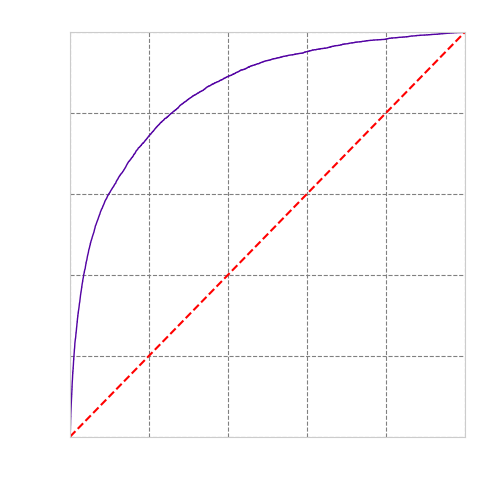

AUC Score:  0.8543


In [ ]:
# Assuming X_train_scaled and y_train are defined
logit = LogisticRegression(random_state=123, solver='saga', penalty='l1', class_weight='balanced', C=1.0, max_iter=500)
logit.fit(X_train_scaled, y_train)

# Get prediction probabilities
logit_scores_prob = logit.predict_proba(X_train_scaled)
y_prob = logit_scores_prob[:,1]

# Calculate ROC curve
fpr, tpr, threshold = roc_curve(y_train, y_prob)
roc_auc_prob = auc(fpr, tpr)

# ROC curve for Probability
plot_roc_curve(fpr, tpr)
roc_auc = auc(fpr, tpr)
print('AUC Score: ', round(roc_auc, 4))


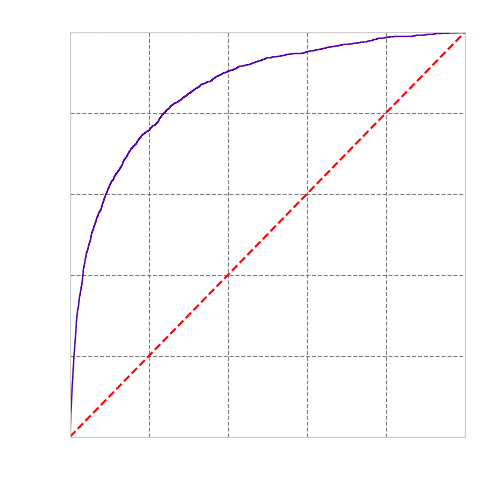

AUC Score :  0.8613


In [ ]:
# Get prediction probabilities for X_test
logit_scores_prob_val = logit.predict_proba(X_test_scaled)
y_prob = logit_scores_prob_val[:,1]

# Calculate ROC curve
fpr_val, tpr_val, thresh_val = roc_curve(y_test, y_prob)
plot_roc_curve(fpr_val, tpr_val)
roc_auc_val = auc(fpr_val, tpr_val)
print('AUC Score : ', round(roc_auc_val, 4))

In [ ]:
# Set a threshold for binary predictions
threshold = 0.5  # Adjust as needed

# Convert probabilities to binary predictions
y_pred = (y_prob >= threshold).astype(int)

# Calculate evaluation metrics
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_prob)
prc_auc = average_precision_score(y_test, y_prob)


# Print the evaluation metrics
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')
print(f'ROC AUC: {roc_auc:.4f}')
print(f'PRC AUC: {prc_auc:.4f}')

Precision: 0.2192
Recall: 0.7513
F1 Score: 0.3394
ROC AUC: 0.8613
PRC AUC: 0.3862


## XG Boost

In [ ]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

# Set parameters
parameters = {
    "learning_rate": [0.01, 0.05, 0.1],
    "n_estimators": [100, 150, 200],
    "max_depth": [3, 5, 7],
    "scale_pos_weight": [0.9, 0.93],
    }

# Create the model
model = XGBClassifier()

# Create the grid search object
grid_search = GridSearchCV(model, parameters, scoring="roc_auc", n_jobs=-1)

# Fit the model
grid_search.fit(X_train_scaled, y_train)

# Print the best parameters
print(grid_search.best_params_)

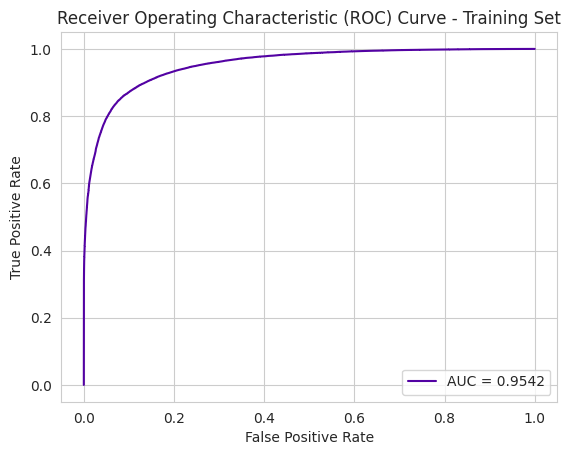

In [ ]:
from imblearn.over_sampling import SMOTE
from sklearn.metrics import roc_curve, auc, roc_auc_score, precision_score, recall_score, f1_score, average_precision_score
from xgboost import XGBClassifier
import matplotlib.pyplot as plt

# Assuming X_train_scaled, y_train, X_test_scaled, and y_test are defined

# Apply SMOTE to balance the classes
smote = SMOTE(random_state=123)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)

# Create XGBoost model on resampled data
clf = XGBClassifier(random_state=123, n_estimators=150, learning_rate=0.05, max_depth=5)
clf.fit(X_train_resampled, y_train_resampled)

# Get prediction probabilities for training set
clf_scores_prob_train = clf.predict_proba(X_train_resampled)
clf_prob_train = clf_scores_prob_train[:, 1]

# Calculate ROC curve for training set
fpr_train, tpr_train, _ = roc_curve(y_train_resampled, clf_prob_train)
roc_auc_train = auc(fpr_train, tpr_train)
plt.figure()
plt.plot(fpr_train, tpr_train, label=f'AUC = {roc_auc_train:.4f}')
plt.title('Receiver Operating Characteristic (ROC) Curve - Training Set')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

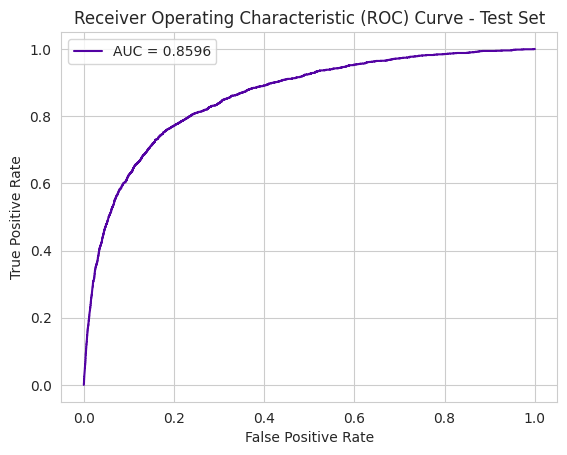

In [ ]:
# Get prediction probabilities for test set
clf_scores_prob_test = clf.predict_proba(X_test_scaled)
clf_prob_test = clf_scores_prob_test[:, 1]

# Calculate ROC curve for test set
fpr_test, tpr_test, _ = roc_curve(y_test, clf_prob_test)
roc_auc_test = auc(fpr_test, tpr_test)
plt.figure()
plt.plot(fpr_test, tpr_test, label=f'AUC = {roc_auc_test:.4f}')
plt.title('Receiver Operating Characteristic (ROC) Curve - Test Set')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

In [ ]:
# Set a threshold for binary predictions
threshold = 0.5  # Adjust as needed

# Convert probabilities to binary predictions for test set
y_pred_test = (clf_prob_test >= threshold).astype(int)

# Calculate evaluation metrics for test set
precision_test = precision_score(y_test, y_pred_test)
recall_test = recall_score(y_test, y_pred_test)
f1_test = f1_score(y_test, y_pred_test)
roc_auc_test = roc_auc_score(y_test, clf_prob_test)
prc_auc_test = average_precision_score(y_test, clf_prob_test)

# Print the evaluation metrics for test set
print(f'Precision (Test): {precision_test:.4f}')
print(f'Recall (Test): {recall_test:.4f}')
print(f'F1 Score (Test): {f1_test:.4f}')
print(f'ROC AUC (Test): {roc_auc_test:.4f}')
print(f'PRC AUC (Test): {prc_auc_test:.4f}')

Precision (Test): 0.3026
Recall (Test): 0.6304
F1 Score (Test): 0.4089
ROC AUC (Test): 0.8596
PRC AUC (Test): 0.3770


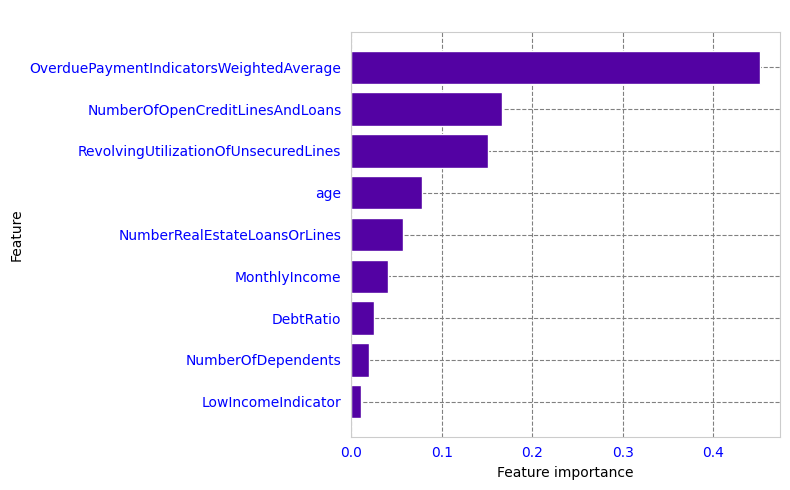

In [ ]:
plot_feature_importances(clf)

## Balanced Random Forest (BRF)

In [ ]:
!pip install imbalanced-learn

/usr/local/lib/python3.10/dist-packages/imblearn/ensemble/_forest.py:546: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/usr/local/lib/python3.10/dist-packages/imblearn/ensemble/_forest.py:558: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


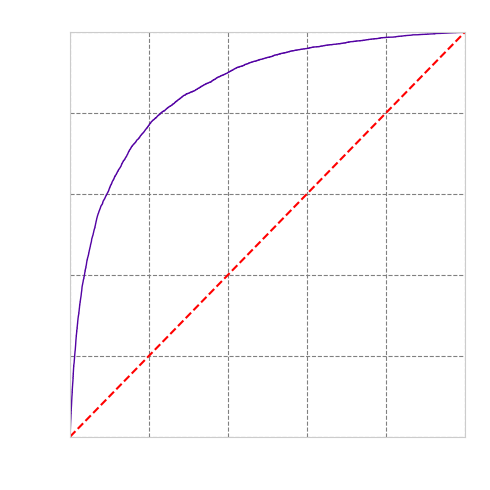

AUC Score (Training):  0.8626


In [ ]:
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.metrics import roc_curve, auc, roc_auc_score, precision_score, recall_score, f1_score, average_precision_score
import matplotlib.pyplot as plt

# Assuming X_train_scaled and y_train are defined

# Create Balanced Random Forest model
brf = BalancedRandomForestClassifier(n_estimators=150, random_state=123, max_depth=5)

# Fit the model
brf.fit(X_train_scaled, y_train)

# Get prediction probabilities for training set
brf_scores_prob_train = brf.predict_proba(X_train_scaled)
brf_prob_train = brf_scores_prob_train[:, 1]

# Calculate ROC curve for training set
fpr_train, tpr_train, _ = roc_curve(y_train, brf_prob_train)
roc_auc_train = auc(fpr_train, tpr_train)
plot_roc_curve(fpr_train, tpr_train)
print('AUC Score (Training): ', round(roc_auc_train, 4))

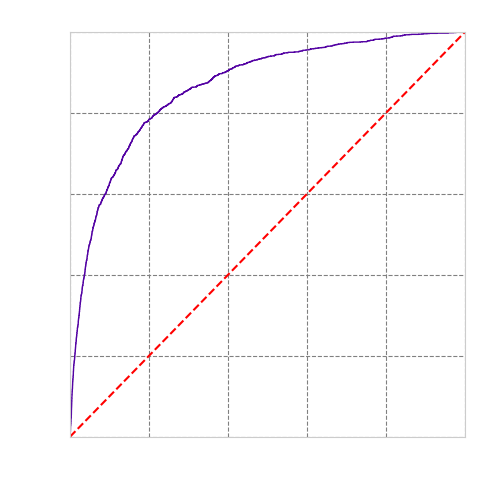

AUC Score (Test):  0.8656


In [ ]:
# Get prediction probabilities for test set
brf_scores_prob_test = brf.predict_proba(X_test_scaled)
brf_prob_test = brf_scores_prob_test[:, 1]

# Calculate ROC curve for test set
fpr_test, tpr_test, _ = roc_curve(y_test, brf_prob_test)
roc_auc_test = auc(fpr_test, tpr_test)
plot_roc_curve(fpr_test, tpr_test)
print('AUC Score (Test): ', round(roc_auc_test, 4))

In [ ]:
# Set a threshold for binary predictions
threshold = 0.5  # Adjust as needed

# Convert probabilities to binary predictions for test set
y_pred_test = (brf_prob_test >= threshold).astype(int)

# Calculate evaluation metrics for test set
precision_test = precision_score(y_test, y_pred_test)
recall_test = recall_score(y_test, y_pred_test)
f1_test = f1_score(y_test, y_pred_test)
roc_auc_test = roc_auc_score(y_test, brf_prob_test)
prc_auc_test = average_precision_score(y_test, brf_prob_test)

# Print the evaluation metrics for test set
print(f'Precision (Test): {precision_test:.4f}')
print(f'Recall (Test): {recall_test:.4f}')
print(f'F1 Score (Test): {f1_test:.4f}')
print(f'ROC AUC (Test): {roc_auc_test:.4f}')
print(f'PRC AUC (Test): {prc_auc_test:.4f}')

Precision (Test): 0.2051
Recall (Test): 0.7991
F1 Score (Test): 0.3264
ROC AUC (Test): 0.8656
PRC AUC (Test): 0.3699


## Ensemble

/usr/local/lib/python3.10/dist-packages/imblearn/ensemble/_forest.py:546: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/usr/local/lib/python3.10/dist-packages/imblearn/ensemble/_forest.py:558: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


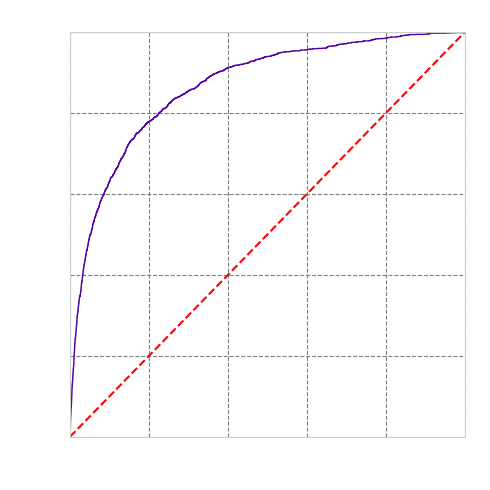

AUC Score :  0.8675


In [ ]:
# Create Model 1 : Balanced Random Forest
model1 = BalancedRandomForestClassifier(n_estimators=150, random_state=123, max_depth=5)
model1.fit(X_train_scaled, y_train)
pred1 = model1.predict_proba(X_test_scaled)
model1.score(X_test_scaled,y_test)

# Create Model 2 : XGBoost
model2 = XGBClassifier( random_state=123, n_estimators=150, learning_rate=0.05, max_depth=5, scale_pos_weight=0.9)
model2.fit(X_train_scaled, y_train)
pred2 = model2.predict_proba(X_test)
model2.score(X_test_scaled,y_test)

# Create Model 3 : Logistic Regression
model3 = LogisticRegression(random_state=123, solver='saga', penalty='l1', class_weight='balanced', C=1.0, max_iter=500)
model3.fit(X_train_scaled, y_train)
pred3 = model3.predict_proba(X_test_scaled)
model3.score(X_test_scaled,y_test)

finalpred = (pred1 + pred2 + pred3)/3

preds = finalpred[:,1]
fpr, tpr, _ = roc_curve(y_test, preds)
plot_roc_curve(fpr,tpr)
print('AUC Score : ', round(roc_auc_score(y_test,preds), 4))

In [ ]:
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy:.4f}")
print("\n\nConfusion Matrix:")
print(conf_matrix)
print("\n\nClassification Report:")
print(classification_rep)

Accuracy: 0.8402


Confusion Matrix:
[[24102  3912]
 [  882  1104]]


Classification Report:
              precision    recall  f1-score   support

         0.0       0.96      0.86      0.91     28014
         1.0       0.22      0.56      0.32      1986

    accuracy                           0.84     30000
   macro avg       0.59      0.71      0.61     30000
weighted avg       0.92      0.84      0.87     30000

